<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter10/calibration_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some parts of this notebook are adapted from : https://colab.research.google.com/github/vinayprabhu/Favorite_PyPi_2020/blob/main/Colab_Pypi_Top10.ipynb#scrollTo=nOhda_pXdW4D

In [2]:
!pip install --quiet torch torchvision netcal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 6.9 MB/s eta 0:00:00


In [6]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from netcal.presentation import ReliabilityDiagram

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Prepare data.
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


# Create a model.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x


model = Net()

# Compile, train, and evaluate.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training
for epoch in range(10):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
correct = 0
total = 0
predicted_probs = []
true_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_probs.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))

100%|██████████| 9912422/9912422 [00:00<00:00, 107508284.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111440380.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41290629.44it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18974630.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Accuracy of the network on the test images: 96 %


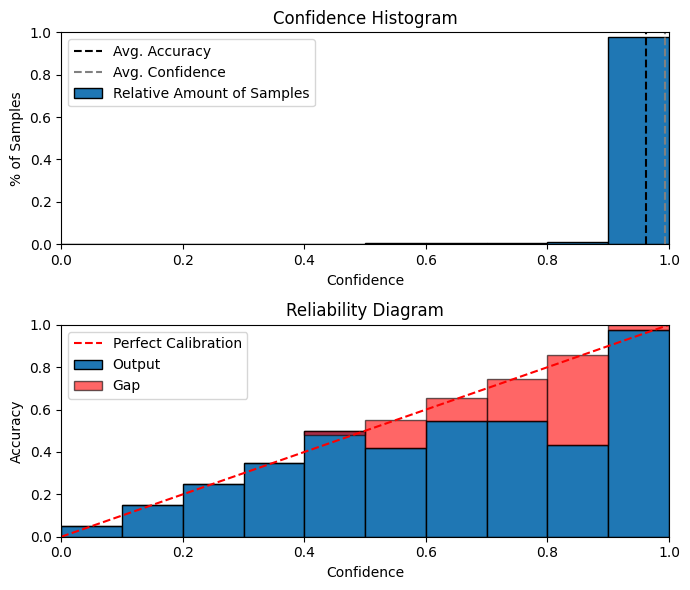

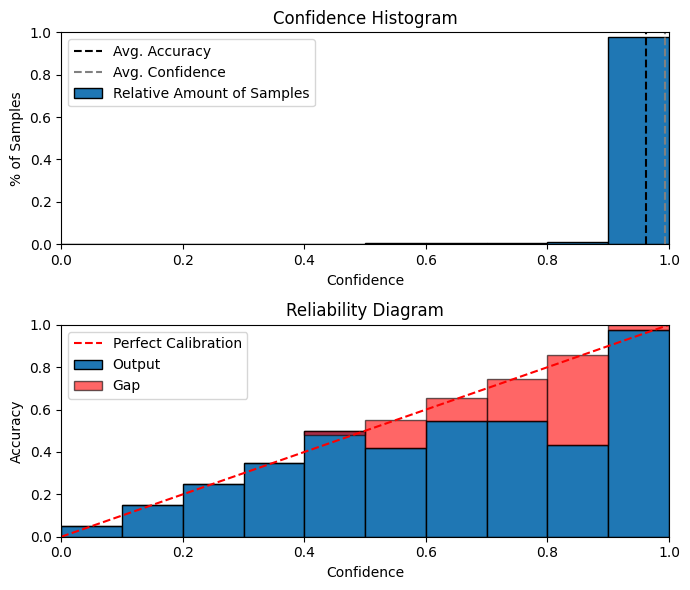

In [7]:
import numpy as np

diagram = ReliabilityDiagram(10)
diagram.plot(np.array(predicted_probs), np.array(true_labels))

# Adding ECE and MCE values as well to the plot

ece_score:  0.030396782621741267
mce_score:  0.42343691965708363


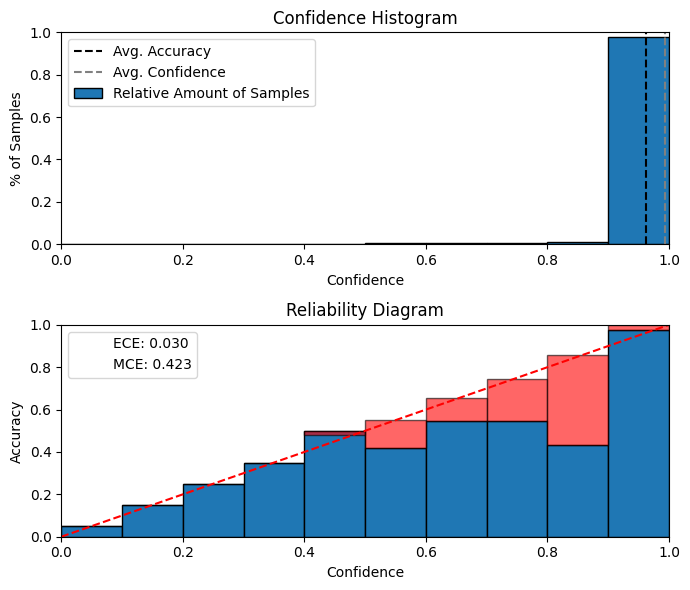

In [8]:
from netcal.metrics import ECE, MCE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

ece = ECE(10)
mce = MCE()

ece_score = ece.measure(np.array(predicted_probs), np.array(true_labels))
mce_score = mce.measure(np.array(predicted_probs), np.array(true_labels))
print("ece_score: ", ece_score)
print("mce_score: ", mce_score)

# Reliability Diagram
# plt.rcParams["figure.figsize"] = (10,10)
diagram = ReliabilityDiagram(bins=10)
diagram.plot(np.array(predicted_probs), np.array(true_labels))

# # Creating legend with color box
pop_a = mpatches.Patch(color="#FFFFFF", label=f"ECE: {ece_score:.3f}")
pop_b = mpatches.Patch(color="#FFFFFF", label=f"MCE: {mce_score:.3f}")

plt.legend(handles=[pop_a, pop_b])

plt.show()